In [1]:
%matplotlib widget
import os
# Avoid Tensorflow yelling
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from copy import deepcopy
from numpy.lib.stride_tricks import sliding_window_view
from pe_extractor.cnn import generator_nsb
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import tensorflow as tf

import importlib
import signal_sense
from signal_sense import accuracy_m, precision_m, recall_m, f1_m, get_model_summary
import pyeventio_binary_reader
from pyeventio_binary_reader import *

import itertools
import operator

importlib.reload(signal_sense)
importlib.reload(pyeventio_binary_reader)

<module 'pyeventio_binary_reader' from '/mnt/c/Users/yannis/Desktop/Hepia/Year4/projet_semestre_terzina/signal_sense/pyeventio_binary_reader.py'>

In [2]:
# generator variables
n_sample = 200000
n_sample_init = 0
batch_size = 1
shift_proba_bin = 30
sigma_smooth_pe_ns = 0 #2.
bin_size_ns = 0.20
sampling_rate_mhz = 1000 #200 MHz is the sampling rate of terzina
                        #250 SST1M
                        #1000 LST + MST
                        #résolution 100 picosecondes 
pe_rate_mhz = 150 # 1 to 150 MHz
noise_lsb=4. # 3.5 to 5.5 options
amplitude_gain=16.
relative_gain_std=0.05
# -------------------------------
# Generator data
# -------------------------------
sampling_period_s = 1 / (sampling_rate_mhz * 1e6)
bin_per_sample = ceil(((sampling_period_s) * 1e9) / bin_size_ns)

gen = generator_nsb(
    n_event=None, batch_size=batch_size, n_sample=n_sample + n_sample_init,
    n_sample_init=n_sample_init, pe_rate_mhz=pe_rate_mhz,
    bin_size_ns=bin_size_ns, sampling_rate_mhz=sampling_rate_mhz,
    amplitude_gain=amplitude_gain, noise_lsb=noise_lsb,
    sigma_smooth_pe_ns=sigma_smooth_pe_ns, baseline=0,
    relative_gain_std=relative_gain_std, shift_proba_bin=shift_proba_bin, dtype=np.float64,
    template_path='pulse_templates/LST_template_3ns.txt'
)

print(f"Using sampling period of {sampling_period_s}s")
print(f"Having {bin_per_sample} bins for every sample")

Using sampling period of 1e-09s
Having 5 bins for every sample


In [5]:
def ns_scale(start, size, resolution = 1):
    return np.linspace((sampling_period_s * 1e9) * start, (sampling_period_s * 1e9) * (start+size), num=size * resolution)

# CNN search

In [3]:
# Model dependant variables
train_size = int(0.8 * n_sample)
window_size = 21
conv_size = 11

data = next(gen)
summed_bins = np.sum(data[1][0].reshape(-1, bin_per_sample), axis=1)
print("Generated data : ", data[0][0].shape)
print("Generated outputs : ", summed_bins.shape)
# summed_bins_bool = list(map(lambda x: 1 if x > 0 else 0, summed_bins))


sample_weights = signal_sense.compute_sample_weights(summed_bins)
print("Generated weights : ", sample_weights.shape)

sliced_data = sliding_window_view(data[0][0], window_size)
sliced_results = sliding_window_view(summed_bins, window_size)
sliced_weights = np.average(sliding_window_view(sample_weights, window_size), axis=1)
print(f"Sliced : data={sliced_data.shape}, results={sliced_results.shape}, weights={sliced_weights.shape}")
# print(sliced_weights)

# split the data into training/test data
dataset = list(zip(deepcopy(sliced_data), deepcopy(sliced_results), deepcopy(sliced_weights)))
# np.random.shuffle(dataset)

train_dataset, val_dataset = dataset[:train_size], dataset[train_size:]
np.random.shuffle(train_dataset)
train_data, train_results, train_weights = zip(*train_dataset)
train_data, train_results, train_weights = np.asarray(train_data), np.asarray(train_results), np.asarray(train_weights)
val_data, val_results, val_weights = zip(*val_dataset)
val_data, val_results, val_weights = np.asarray(val_data), np.asarray(val_results), np.asarray(val_weights)
print(f"Train : data={train_data.shape}, results={train_results.shape}, weights={train_weights.shape}")
print(f"Validation : data={val_data.shape}, results={val_results.shape}, weights={val_weights.shape}")

Generated data :  (200000,)
Generated outputs :  (200000,)
Generated weights :  (200000,)
Sliced : data=(199980, 21), results=(199980, 21), weights=(199980,)
Train : data=(160000, 21), results=(160000, 21), weights=(160000,)
Validation : data=(39980, 21), results=(39980, 21), weights=(39980,)


In [4]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=functools.partial(signal_sense.build_cnn_model, window_size=window_size),
#     objective="val_loss",
#     max_trials=5,
#     overwrite=True,
#     directory="tmp/signal_sense_search",
#     project_name="signal_sense_cnn",
# )

In [5]:
# log_dir = f"tmp/logs/manual_fit"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# tuner.search(train_data, train_results, sample_weight=train_weights, epochs=50, validation_data=(val_data, val_results), callbacks=[tensorboard_callback])
# best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 17m 06s]
val_loss: 0.4754331409931183

Best val_loss So Far: 0.43628397583961487
Total elapsed time: 01h 08m 18s


In [14]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(8, (conv_size)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(window_size, activation='relu'),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 8)             96        
                                                                 
 dropout_2 (Dropout)         (None, 11, 8)             0         
                                                                 
 flatten_2 (Flatten)         (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                5696      
                                                                 
 dense_3 (Dense)             (None, 21)                1365      
                                                      

In [15]:
model_name = 'manual_fit_2'

checkpoint_filepath = f'./tmp/{model_name}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

log_dir = f"tmp/logs/manual_fit/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Get model summary
model_summary_str = get_model_summary(model)
# Log directory for TensorBoard
file_writer = tf.summary.create_file_writer(log_dir)
# Write the model summary to TensorBoard
with file_writer.as_default():
    tf.summary.text("Model Summary", model_summary_str, step=0)

model.compile(optimizer=adam_optimizer,
              loss='mse',
              metrics=[precision_m, recall_m, f1_m])
#sample_weight=train_weights
history = model.fit(train_data, train_results, epochs=50, validation_data=(val_data, val_results), callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/50
5000/5000 [==============================] - 17s 3ms/step - loss: 0.1221 - precision_m: 0.6615 - recall_m: 0.2067 - f1_m: 0.3113 - val_loss: 0.1206 - val_precision_m: 0.6944 - val_recall_m: 0.1860 - val_f1_m: 0.2789
Epoch 2/50
5000/5000 [==============================] - 16s 3ms/step - loss: 0.1203 - precision_m: 0.6728 - recall_m: 0.2107 - f1_m: 0.3169 - val_loss: 0.1203 - val_precision_m: 0.6933 - val_recall_m: 0.2049 - val_f1_m: 0.3041
Epoch 3/50
5000/5000 [==============================] - 15s 3ms/step - loss: 0.1201 - precision_m: 0.6718 - recall_m: 0.2106 - f1_m: 0.3167 - val_loss: 0.1200 - val_precision_m: 0.6724 - val_recall_m: 0.2398 - val_f1_m: 0.3395
Epoch 4/50
5000/5000 [==============================] - 15s 3ms/step - loss: 0.1200 - precision_m: 0.6734 - recall_m: 0.2111 - f1_m: 0.3175 - val_loss: 0.1201 - val_precision_m: 0.6692 - val_recall_m: 0.2340 - val_f1_m: 0.3324
Epoch 5/50
5000/5000 [==============================] - 15s 3ms/step - loss: 0.1199 - precis

# RNN Search

In [40]:
# CNN variables
train_size = int(0.8 * n_sample)
window_size = 21
conv_size = 11

data = next(gen)
summed_bins = np.sum(data[1][0].reshape(-1, bin_per_sample), axis=1)
print("Generated data : ", data[0][0].shape)
print("Generated outputs : ", summed_bins.shape)
# summed_bins_bool = list(map(lambda x: 1 if x > 0 else 0, summed_bins))

sample_weights = signal_sense.compute_sample_weights(summed_bins)
print("Generated weights : ", sample_weights.shape)

sliced_data = sliding_window_view(data[0][0], window_size)
sliced_results = sliding_window_view(summed_bins, window_size)
sliced_weights = np.average(sliding_window_view(sample_weights, window_size), axis=1)
print(f"Sliced : data={sliced_data.shape}, results={sliced_results.shape}, weights={sliced_weights.shape}")
# print(sliced_weights)

# split the data into training/test data
dataset = list(zip(deepcopy(sliced_data), deepcopy(sliced_results), deepcopy(sliced_weights)))
# np.random.shuffle(dataset)

train_dataset, val_dataset = dataset[:train_size], dataset[train_size:]
train_data, train_results, train_weights = zip(*train_dataset)
train_data, train_results, train_weights = np.asarray(train_data), np.asarray(train_results), np.asarray(train_weights)
val_data, val_results, val_weights = zip(*val_dataset)
val_data, val_results, val_weights = np.asarray(val_data), np.asarray(val_results), np.asarray(val_weights)
print(f"Train : data={train_data.shape}, results={train_results.shape}, weights={train_weights.shape}")
print(f"Validation : data={val_data.shape}, results={val_results.shape}, weights={val_weights.shape}")

Generated data :  (200000,)
Generated outputs :  (200000,)
Generated weights :  (200000,)
Sliced : data=(199980, 21), results=(199980, 21), weights=(199980,)
Train : data=(160000, 21), results=(160000, 21), weights=(160000,)
Validation : data=(39980, 21), results=(39980, 21), weights=(39980,)


In [16]:
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.LSTM(50, input_shape=(window_size, 1), activation='relu'))  # 50 units in the RNN layer
rnn_model.add(tf.keras.layers.Dense(window_size))  # Output layer for regression

rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 21)                1071      
                                                                 
Total params: 3671 (14.34 KB)
Trainable params: 3671 (14.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model_name = 'manual_fit_lstm_1'

checkpoint_filepath = f'./tmp/{model_name}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

log_dir = f"tmp/logs/manual_fit/{model_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Get model summary
model_summary_str = get_model_summary(rnn_model)
# Log directory for TensorBoard
file_writer = tf.summary.create_file_writer(log_dir)
# Write the model summary to TensorBoard
with file_writer.as_default():
    tf.summary.text("Model Summary", model_summary_str, step=0)

rnn_model.compile(optimizer=adam_optimizer,
              loss='mse',
              metrics=[precision_m, recall_m, f1_m])
#sample_weight=train_weights
history = rnn_model.fit(train_data, train_results, epochs=50, validation_data=(val_data, val_results), callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/50
5000/5000 [==============================] - 51s 10ms/step - loss: 0.0784 - precision_m: 0.7234 - recall_m: 0.5838 - f1_m: 0.6445 - val_loss: 0.0799 - val_precision_m: 0.6858 - val_recall_m: 0.6475 - val_f1_m: 0.6623
Epoch 2/50
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0785 - precision_m: 0.7226 - recall_m: 0.5839 - f1_m: 0.6443 - val_loss: 0.0802 - val_precision_m: 0.6921 - val_recall_m: 0.6407 - val_f1_m: 0.6614
Epoch 3/50
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0784 - precision_m: 0.7235 - recall_m: 0.5831 - f1_m: 0.6441 - val_loss: 0.0787 - val_precision_m: 0.7366 - val_recall_m: 0.5740 - val_f1_m: 0.6408
Epoch 4/50
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0784 - precision_m: 0.7236 - recall_m: 0.5835 - f1_m: 0.6444 - val_loss: 0.0797 - val_precision_m: 0.7118 - val_recall_m: 0.6036 - val_f1_m: 0.6495
Epoch 5/50
5000/5000 [==============================] - 50s 10ms/step - loss: 0.0784 - p

# TensorBoard training visualisation
Launch the command `tensorboard --logdir tmp/logs/{fit_folder}` in the terminal and access the website link.

# Data and results visualisation


event where pe > 0 [[ 1726    14]
 [ 1907    15]
 [ 2062    14]
 [ 2226    18]
 [ 2322     6]
 [ 2561    17]
 [ 3106    20]
 [ 3930     0]
 [ 4462    16]
 [ 4866     6]
 [ 4942     0]
 [ 5020    10]
 [ 7124    13]
 [ 9671    20]
 [10016    16]
 [10062     8]
 [11296    15]
 [11638     7]
 [11638     8]
 [12929    10]
 [12929    11]
 [13990     7]
 [14162    14]
 [15517     3]
 [16774    14]
 [17511     5]
 [18720     1]
 [20275     0]
 [20809     9]
 [21704    15]
 [22967    10]
 [23161    10]
 [23635    14]
 [23635    15]
 [24346    10]
 [25738    15]
 [26173    14]
 [28180    18]
 [28428     7]
 [29652     3]
 [31438     4]
 [31632    19]
 [31811    11]
 [32426    19]
 [32779     0]
 [33347     4]
 [34136    19]
 [34154    13]
 [34528     2]
 [35003     3]
 [36761    14]
 [36999     9]
 [37463     1]
 [39850    17]
 [40629     5]
 [40943     1]
 [41162    12]
 [41302     1]
 [41846    15]
 [42243    10]
 [42723    10]
 [43531    12]
 [43666    17]
 [43888     5]
 [44206     0]
 [4460

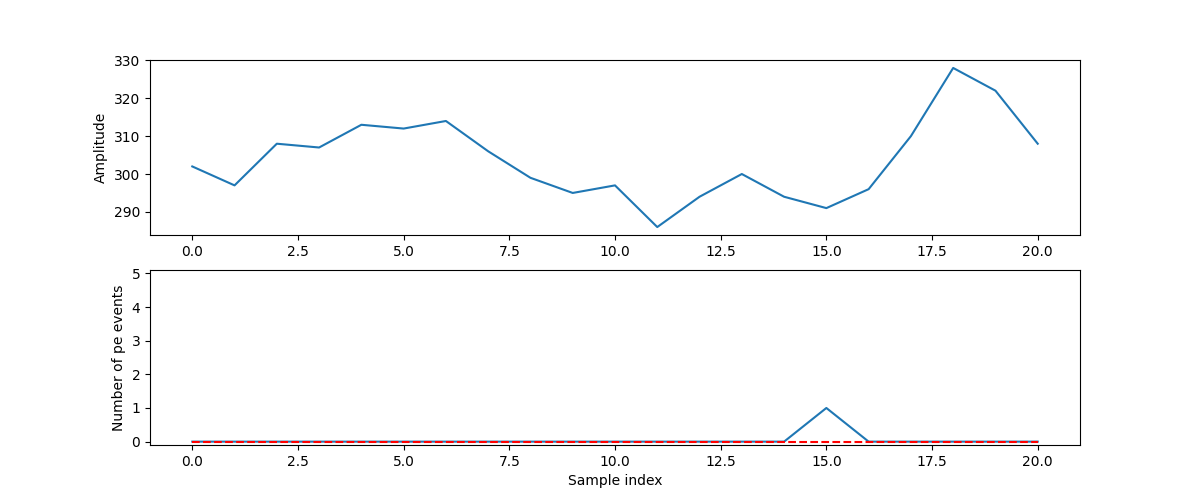

In [19]:
model = rnn_model
# --------------------------------
# Moving window display
# --------------------------------
i = 0
resultsYMax = np.max(val_results) + 0.1
fig = plt.figure(figsize=(12, 5))

def update():
    plt.clf()
    ax1 = plt.subplot(211)
    ax1.plot(val_data[i], label='Sensor data')
    ax1.set_ylabel('Amplitude')
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.set_ylim(-0.1,resultsYMax)
    ax2.set_ylabel('Number of pe events')
    ax2.plot(val_results[i], label='Truth')
    # [None, ] is for the batch array dimension, since it's a single event, just add none
    ax2.plot(model.predict(val_data[i][None,], verbose=0)[0], '--r', label='Prediction')
    plt.xlabel('Sample index')
    plt.draw()

def press(event):
    global i, ax1, ax2
    # Move window left or right
    if event.key == 'left':
        i-=1
    elif event.key == 'right':
        i+=1
    update()

fig.canvas.mpl_connect('key_press_event', press)
update()
plt.show()

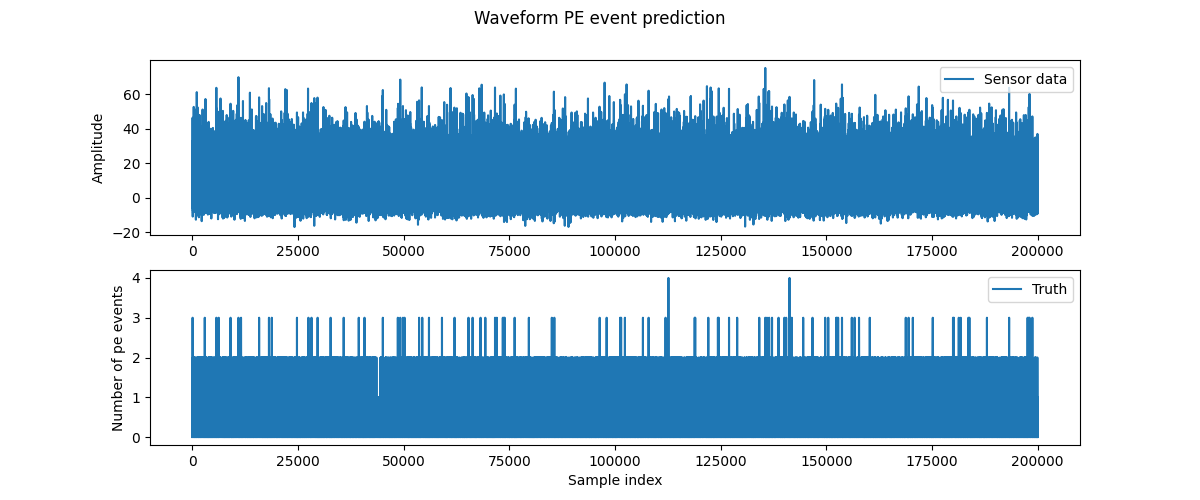

In [6]:
# --------------------------------
# Whole waveform display
# --------------------------------

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Waveform PE event prediction')
ax1 = plt.subplot(211)
ax1.plot(data[0][0], label='Sensor data')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylabel('Number of pe events')
ax2.plot(summed_bins, label='Truth')
# results = model.predict(sliced_data)
# avg_results = signal_sense.reaggregate_windows_avg(results, window_size, window_size-1)
# ax2.plot(avg_results, label='Prediction')
ax2.legend()
plt.xlabel('Sample index')

plt.show()

# Model's metrics with different configurations

In [37]:
configs = {
    "pe_rate_mhz": [20,50,64,150], # 1 to 150 MHz [20,32,50,64,128,150]
    "noise_lsb": np.arange(0, 1.51, 0.25), # 0 to 1.5 noise
}

metrics_result = signal_sense.run_tests(model, configs, window_size)

Running 28 tests on model
RUN_0: config={'pe_rate_mhz': 20, 'noise_lsb': 0.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_1: config={'pe_rate_mhz': 20, 'noise_lsb': 0.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_2: config={'pe_rate_mhz': 20, 'noise_lsb': 0.5} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_3: config={'pe_rate_mhz': 20, 'noise_lsb': 0.75} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_4: config={'pe_rate_mhz': 20, 'noise_lsb': 1.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_5: config={'pe_rate_mhz': 20, 'noise_lsb': 1.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_6: config={'pe_rate_mhz': 20, 'noise_lsb': 1.5} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_7: config={'pe_rate_mhz': 50, 'noise_lsb': 0.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_8: config={'pe_rate_mhz': 50, 'noise_lsb': 0.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_9: 

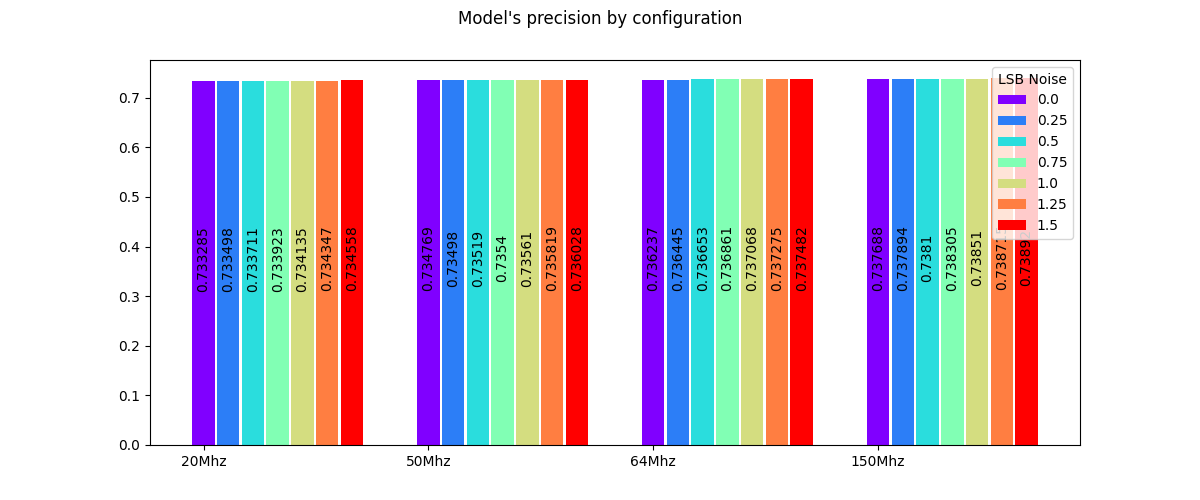

In [38]:
grouped_by_pe_rate = [{ "label": f"{k}Mhz", "data" : list(g)} for k, g in itertools.groupby(metrics_result, key=operator.itemgetter('pe_rate_mhz'))]

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Model\'s precision by configuration')

x = np.arange(len(grouped_by_pe_rate))
bar_width = 0.1
bar_colormap = signal_sense.get_colormap(configs["noise_lsb"])

bar_labels = []
bar_values = []
bar_locations = []
bar_colors = []

ax = fig.subplots(1)
for i, entry in enumerate(grouped_by_pe_rate):    
    bar_labels.extend([x["noise_lsb"] for x in entry["data"]])
    cur_values = [x["precision_m"] for x in entry["data"]]
    bar_values.extend(cur_values)
    bar_locations.extend(i + np.arange(len(cur_values)) * (bar_width + 0.01))
    bar_colors.extend([bar_colormap[str(x["noise_lsb"])] for x in entry["data"]])
    
rects = ax.bar(bar_locations, bar_values, bar_width, label=bar_labels, color=bar_colors)
ax.bar_label(rects, label_type='center', rotation = 90, padding=3)

# Add X axis labels
ax.set_xticks(x, [x["label"] for x in grouped_by_pe_rate])

# Draw color legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="LSB Noise")

plt.show()

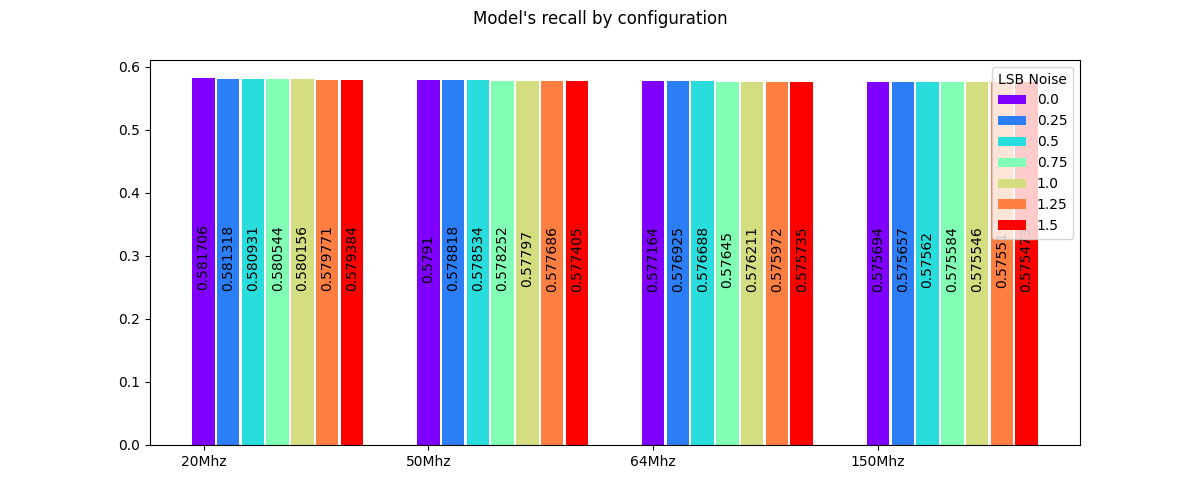

In [39]:
grouped_by_pe_rate = [{ "label": f"{k}Mhz", "data" : list(g)} for k, g in itertools.groupby(metrics_result, key=operator.itemgetter('pe_rate_mhz'))]

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Model\'s recall by configuration')

x = np.arange(len(grouped_by_pe_rate))
bar_width = 0.1
bar_colormap = signal_sense.get_colormap(configs["noise_lsb"])

bar_labels = []
bar_values = []
bar_locations = []
bar_colors = []

ax = fig.subplots(1)
for i, entry in enumerate(grouped_by_pe_rate):    
    bar_labels.extend([x["noise_lsb"] for x in entry["data"]])
    cur_values = [x["recall_m"] for x in entry["data"]]
    bar_values.extend(cur_values)
    bar_locations.extend(i + np.arange(len(cur_values)) * (bar_width + 0.01))
    bar_colors.extend([bar_colormap[str(x["noise_lsb"])] for x in entry["data"]])
    
rects = ax.bar(bar_locations, bar_values, bar_width, label=bar_labels, color=bar_colors)
ax.bar_label(rects, label_type='center', rotation = 90, padding=3)

# Add X axis labels
ax.set_xticks(x, [x["label"] for x in grouped_by_pe_rate])

# Draw color legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="LSB Noise")

plt.show()

In [15]:
model = tf.keras.models.load_model('tmp/manual_fit_leonid_rnn_batchnorm.keras', 
                                   custom_objects={
                                       "precision_m": precision_m,
                                       "recall_m": recall_m,
                                       "f1_m": f1_m
                                       })

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Bat  (None, 21, 1)             4         
 chNormalization)                                                
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 21)                1071      
                                                                 
Total params: 3675 (14.36 KB)
Trainable params: 3673 (14.35 KB)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________
